<a href="https://www.kaggle.com/code/duaanaz/face-recognition?scriptVersionId=250893056" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Load important libraries
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Set the plotting style
plt.style.use('ggplot')


In [2]:
# Load pre-trained Haar Cascade classifiers for face, eyes, smile, and nose detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_smile.xml")
# nose_cascade = cv2.CascadeClassifier(os.path.expanduser("~/haarcascade_mcs_nose.xml"))


In [3]:
base = '../input/students-images/'
student_ids = [d for d in sorted(os.listdir(base)) if os.path.isdir(os.path.join(base, d)) and d.isdigit()]

In [4]:
# Making data frame
df = []
for sid in student_ids:
    path_test = os.path.join(base, sid,sid, '*.jpg')
    paths = sorted(glob(path_test)) 
    for p in paths:
        img = cv2.imread(p)
        if img is None:
            print("there is no image")
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        df.append({
            'student_id': sid,
            'path': p,
            'height': img.shape[0],
            'width': img.shape[1],
            'aspect_ratio': img.shape[1] / img.shape[0],
            'brightness': np.mean(gray),
            'contrast': np.std(gray),
            'blur_score': cv2.Laplacian(gray, cv2.CV_64F).var()
        })

# Convert the list to a DataFrame
df = pd.DataFrame(df)


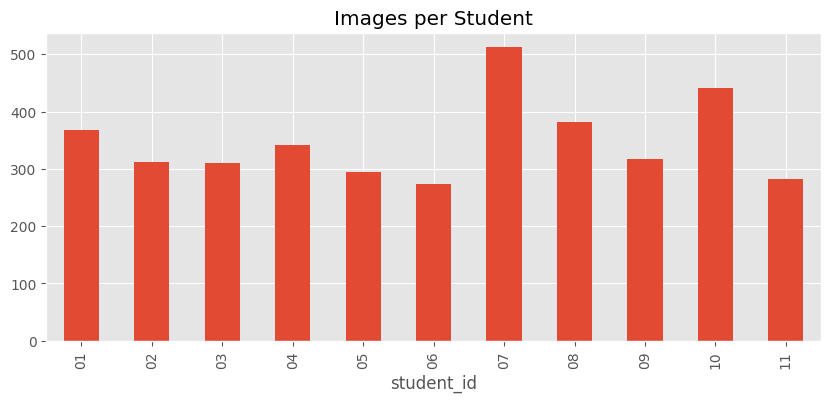

<Figure size 1000x400 with 0 Axes>

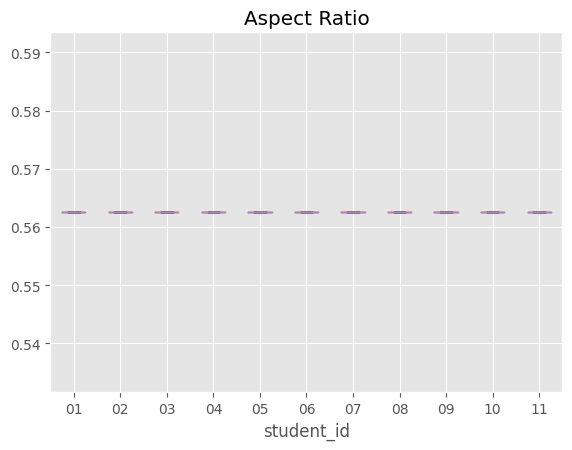

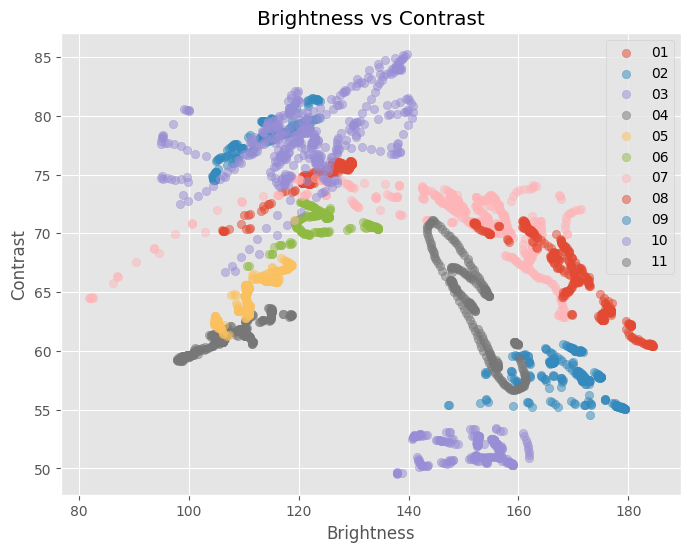

<Figure size 1000x400 with 0 Axes>

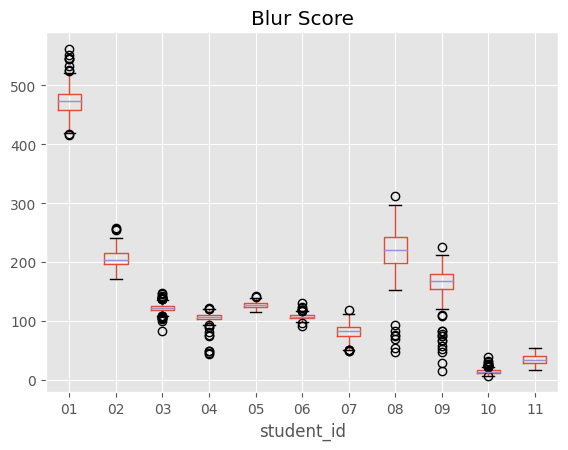

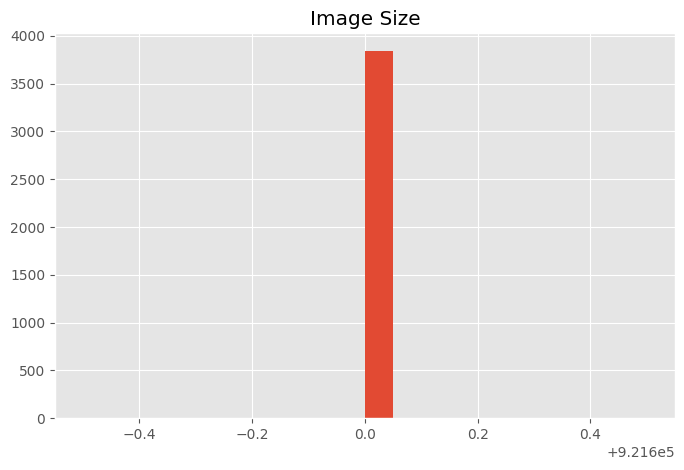

In [5]:
# EDA

plt.figure(figsize=(10, 4))
df['student_id'].value_counts().sort_index().plot(kind='bar')
plt.title("Images per Student")
plt.show()

plt.figure(figsize=(10, 4))
df.boxplot(column='aspect_ratio', by='student_id')
plt.title("Aspect Ratio")
plt.suptitle("")
plt.show()

plt.figure(figsize=(8, 6))
for sid in df['student_id'].unique():
    sub = df[df['student_id'] == sid]
    plt.scatter(sub['brightness'], sub['contrast'], label=sid, alpha=0.5)
plt.legend()
plt.xlabel("Brightness")
plt.ylabel("Contrast")
plt.title("Brightness vs Contrast")
plt.show()

plt.figure(figsize=(10, 4))
df.boxplot(column='blur_score', by='student_id')
plt.title("Blur Score")
plt.suptitle("")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(df['width'] * df['height'], bins=20)
plt.title("Image Size")
plt.show()


Extracting HOG features...
Training SVM...
Training complete.
Accuracy: 0.9907292954264524
              precision    recall  f1-score   support

          01       1.00      1.00      1.00       173
          02       1.00      0.98      0.99       105
          03       1.00      1.00      1.00       151
          04       1.00      1.00      1.00       161
          05       1.00      1.00      1.00       146
          06       1.00      0.99      1.00       135
          07       0.99      0.98      0.98       193
          08       0.97      0.99      0.98       139
          09       0.96      0.99      0.98       130
          10       0.99      0.98      0.99       171
          11       0.98      0.98      0.98       114

    accuracy                           0.99      1618
   macro avg       0.99      0.99      0.99      1618
weighted avg       0.99      0.99      0.99      1618



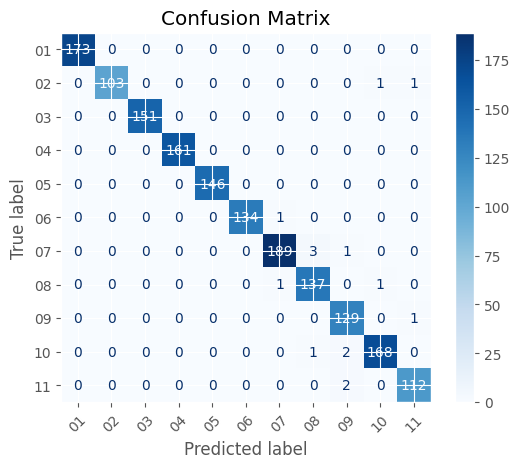

In [6]:
# Model training
X_train, X_test, y_train, y_test = [], [], [], []
le = LabelEncoder()

print("Extracting HOG features...")
for sid in student_ids:
    feats = []
    paths = sorted(glob(os.path.join(base, sid,sid, '*.jpg')))
    for p in paths:
        img = cv2.imread(p)
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        if len(faces) == 0:
            continue
        x, y, w, h = max(faces, key=lambda r: r[2] * r[3])
        face = gray[y:y + h, x:x + w]
        if np.var(face) < 100:
            continue
        face = cv2.resize(face, (100, 100)).astype('float32') / 255.0
        feats.append(hog(face, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True))
    
    if len(feats) >= 2:
        a, b = train_test_split(feats, test_size=0.5, random_state=42)
        X_train += a
        X_test += b
        y_train += [sid] * len(a)
        y_test += [sid] * len(b)

# Encode the labels
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("Training SVM...")
model = SVC(kernel='linear', probability=True).fit(X_train, y_train_enc)
print("Training complete.")

# --- Evaluation ---
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test_enc, y_pred))
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))
ConfusionMatrixDisplay(confusion_matrix(y_test_enc, y_pred), display_labels=le.classes_).plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


HOG Visualization Example:


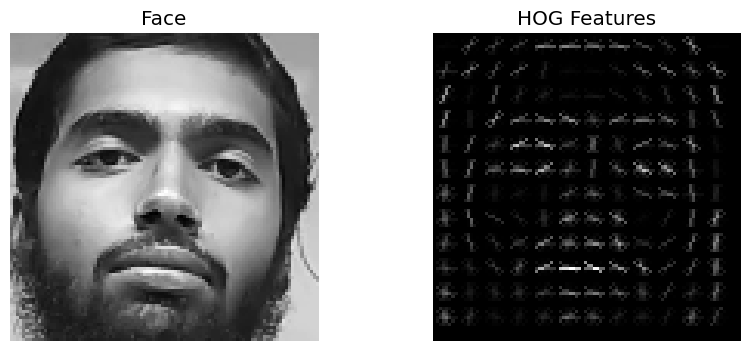

In [7]:
# --- HOG Visualization ---
print("\nHOG Visualization Example:")
sample = '../input/students-images/04/04/frame_00000.jpg'
img = cv2.imread(sample)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.1, 5)
if len(faces):
    x, y, w, h = max(faces, key=lambda r: r[2] * r[3])
    face = cv2.resize(gray[y:y + h, x:x + w], (100, 100)).astype('float32') / 255.0
    features, hog_image = hog(face, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, feature_vector=True)
    hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(face, cmap='gray')
    plt.title("Face")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap='gray')
    plt.title("HOG Features")
    plt.axis('off')
    plt.show()

In [8]:
# --- Real-Time Webcam Recognition ---
# Not implemented succcessfuly yet -- just a sample code
# Webcame is not accessible
def run_webcam():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Webcam not accessible.")
        return
    print("Press 'q' to quit.")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        
        for (x, y, w, h) in faces:
            roi_gray = gray[y:y + h, x:x + w]
            roi_color = frame[y:y + h, x:x + w]
            if np.var(roi_gray) < 100:
                continue
            
            face_resized = cv2.resize(roi_gray, (100, 100)).astype('float32') / 255.0
            feat = hog(face_resized, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True).reshape(1, -1)
            pred = model.predict(feat)[0]
            prob = model.predict_proba(feat).max()
            label = le.inverse_transform([pred])[0] if prob > 0.85 else "Unknown"
            color = (0, 255, 0) if prob > 0.85 else (0, 0, 255)
            
            # Draw rectangle around the face
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, f"{label} ({prob * 100:.1f}%)", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

             # Features inside face only
            face_gray = roi_gray
            face_col = roi_color

            # Detect eyes
            eyes = eye_cascade.detectMultiScale(face_gray, 1.1, 10)
            eyes_filtered = [e for e in eyes if e[1] < h // 2]
            for (ex, ey, ew, eh) in eyes_filtered[:2]:
                cv2.rectangle(face_col, (ex, ey), (ex + ew, ey + eh), (255, 0, 0), 1)

            # Detect nose
            noses = nose_cascade.detectMultiScale(face_gray, 1.1, 10)
            if len(noses):
                nx, ny, nw, nh = min(noses, key=lambda r: abs(r[1] - h // 2))
                cv2.rectangle(face_col, (nx, ny), (nx + nw, ny + nh), (0, 255, 255), 1)

            # Detect smile
            smiles = smile_cascade.detectMultiScale(face_gray, 1.1, 25)
            smiles_filtered = [s for s in smiles if s[1] > h // 2]
            if len(smiles_filtered):
                sx, sy, sw, sh = max(smiles_filtered, key=lambda r: r[2] * r[3])
                cv2.rectangle(face_col, (sx, sy), (sx + sw, sy + sh), (0, 0, 255), 1)

        # Display the frame
        cv2.imshow("Webcam Recognition", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()

# Run the webcam recognition
run_webcam()

Webcam not accessible.


[ WARN:0@793.247] global cap_v4l.cpp:913 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@793.247] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
